**Описание проекта**

Спрогнозировать, уйдёт клиент интернет-проекта в ближайшее время и построить модель с предельно большим значением *F1*-меры. 


**Этапы проекта**

1. Подготовлены данные. В том числе, загружены библиотеки и их компоненты, проанализированы и предварительно обработаны данные. 
1. Исследована задача проекта. Изучены модели без учёта дисбаланса. Подобраны параметров моделей решающего дерева, случайного леса и логистической регрессии для улучшения их качества. Исследован баланс классов. 
1. Проведена борьба с дисбалансом классов за счет увеличения обучающей выборки класса "1", а также за счет уменьшения обучающей выборки класса "0". Сравнены показатели качества моделей с разными способами балансировки обучающей выборки и без балансировки.

Описание атрибутов датафрейма:
1. `Number` — индекс строки 
1. `Id` — Id клиента
1. `UUID` — уникальный идентификатор клиента
1. `City` — город проживания клиента
1. `Gender` — пол
1. `Age` — возраст
1. `YearsRegistration` — сколько лет зарегистрирован
1. `NumOfProducts` — количество продуктов, используемых клиентом 
1. `HasCrCard` — наличие привязанной карты для оплаты услуг
1. `IsActiveMember` — активность клиента
1. `Exited` — признак удаления личного кабинета

## Подготовка данных

In [1]:
import pandas as pd
import numpy as nm

import re
from sklearn.preprocessing import(
    OrdinalEncoder, 
    LabelEncoder, 
    OneHotEncoder, 
    StandardScaler
) 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import(
    mean_absolute_error, 
    accuracy_score, 
    f1_score, 
    roc_curve,
    roc_auc_score
) 

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/pleskaks/Desktop/otus/dataset_new.xlsx'
data = pd.read_excel(path)
print(data.info()) 
data.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Number             10000 non-null  int64  
 1   Id                 10000 non-null  int64  
 2   uuid               10000 non-null  object 
 3   City               10000 non-null  object 
 4   Gender             10000 non-null  object 
 5   Age                10000 non-null  int64  
 6   YearsRegistration  9980 non-null   float64
 7   NumOfProducts      10000 non-null  int64  
 8   HasCard            10000 non-null  int64  
 9   IsActive           10000 non-null  int64  
 10  Exited             10000 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 859.5+ KB
None


,Number,Id,uuid,City,Gender,Age,YearsRegistration,NumOfProducts,HasCard,IsActive,Exited
0,1,15634602,fdcd57e82ffc3f0a94b4c3d966a7c6d891d1e54894492f...,Екатеринбург,Female,42,2.0,1,1,1,1
1,2,15647311,21f5358c1fd3b713a0b8d13634c18d381383d67b2ab0f0...,Санкт-Петербург,Female,41,1.0,1,0,1,0
2,3,15619304,b839933c7be156a656ee5b30a2c7c034ba1851c635166e...,Екатеринбург,Female,42,8.0,3,1,0,1
3,4,15701354,cb1edc7273ba5f307f4914574aaf642914fbfb38ab7572...,Екатеринбург,Female,39,1.0,2,0,0,0
4,5,15737888,483d4bce16af8025b73a0b055655a34de45b7c3628e091...,Санкт-Петербург,Female,43,2.0,1,1,1,0


In [3]:
data.describe()

,Number,Id,Age,YearsRegistration,NumOfProducts,HasCard,IsActive,Exited
count,10000.00000,1.000000e+04,10000.000000,9980.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,38.921800,5.013527,1.530200,0.70550,0.515100,0.203700
std,2886.89568,7.193619e+04,10.487806,2.892453,0.581654,0.45584,0.499797,0.402769
min,1.00000,1.556570e+07,18.000000,0.000000,1.000000,0.00000,0.000000,0.000000
25%,2500.75000,1.562853e+07,32.000000,3.000000,1.000000,0.00000,0.000000,0.000000
50%,5000.50000,1.569074e+07,37.000000,5.000000,1.000000,1.00000,1.000000,0.000000
75%,7500.25000,1.575323e+07,44.000000,8.000000,2.000000,1.00000,1.000000,0.000000
max,10000.00000,1.581569e+07,92.000000,10.000000,4.000000,1.00000,1.000000,1.000000


Атрибуты отличаются друг от друга размерностью. Cбалансируем их для улучшения качества моделей. 

In [4]:
attr = 'Gender'
print(attr, ':', len(data[attr].unique())) 
print(data[attr].unique()) 
print() 

attr = 'City'
print(attr, ':', len(data[attr].unique())) 
print(data[attr].unique()) 
print() 

Gender : 2
['Female' 'Male']

City : 3
['Екатеринбург' 'Санкт-Петербург' 'Москва']



Атрибуты `Gender` и `City` преобразуем методом порядкового кодирования. 
Менее 1% объектов содержат пропуски в атрибуте `YearsRegistration `. Удаление этих объектов не приведёт к потере качества данных датафрейма, а все оставшиеся можно использовать в машиностроению обучении. 
Названия атрибутов не соответствуют "snake case". Приведем их к нижнему регистру. 
Атрибут `uuid` предлагается удалить из датафрейма в силу его предполагаемой недостаточной значимости. 

### Предварительная обработка данных

In [5]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns] 
data.columns

Index(['number', 'id', 'uuid', 'city', 'gender', 'age', 'years_registration',
       'num_of_products', 'has_card', 'is_active', 'exited'],
      dtype='object')

In [6]:
data = data.loc[data['years_registration'].notnull()]

In [7]:
data = data.drop('uuid', axis=1) 

In [8]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number              9980 non-null   int64  
 1   id                  9980 non-null   int64  
 2   city                9980 non-null   object 
 3   gender              9980 non-null   object 
 4   age                 9980 non-null   int64  
 5   years_registration  9980 non-null   float64
 6   num_of_products     9980 non-null   int64  
 7   has_card            9980 non-null   int64  
 8   is_active           9980 non-null   int64  
 9   exited              9980 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 857.7+ KB


Не смотря на то, что все параметры далее будут переведены в числовые значения, в данной задаче требуется классификация по целевому признаку. Поэтому для решения задачи подойдут модели `DecisionTreeClassifier`, `RandomForestClassifier` и `LogisticRegression`.

#### Разделение датафрейма на обучающие, валидационные и тестовые выборки

In [11]:
target = data['exited'] 
features = data.drop(['exited'], axis=1) 

features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=.4,
    stratify=target, 
    random_state=12345
) 
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, 
    target_test, 
    test_size=.5,
    stratify=target_test, 
    random_state=12345
)

print('Размеры выборок:')
print('features.     :', features.shape)
print('target.       :', target.shape)
print('features_train:', features_train.shape)
print('target_train  :', target_train.shape)
print('features_test :', features_test.shape)
print('target_test   :', target_test.shape)
print('features_valid:', features_valid.shape)
print('target_valid  :', target_valid.shape)
print('\nfeatures_test:')
features_test.head()

Размеры выборок:
features.     : (9980, 9)
target.       : (9980,)
features_train: (5988, 9)
target_train  : (5988,)
features_test : (1996, 9)
target_test   : (1996,)
features_valid: (1996, 9)
target_valid  : (1996,)

features_test:


,number,id,city,gender,age,years_registration,num_of_products,has_card,is_active
8335,8336,15737414,Екатеринбург,Male,35,4.0,1,1,0
6136,6137,15773071,Санкт-Петербург,Female,33,6.0,1,1,1
2447,2448,15715769,Екатеринбург,Male,26,2.0,1,0,1
2792,2793,15742820,Екатеринбург,Female,45,2.0,2,0,1
7317,7318,15734008,Москва,Male,59,5.0,1,1,0


Порядковое кодирование категориальных признаков "gender" и "city" для "деревянных" моделей

In [33]:
import numpy as np


encoder = OrdinalEncoder(categories="auto", handle_unknown="use_encoded_value", unknown_value=-1) 
encoder.fit(features_train)

features_train_wooden = pd.DataFrame(
    encoder.transform(features_train), 
    columns=features_train.columns, 
    index=features_train.index
)
features_valid_wooden = pd.DataFrame(
    encoder.transform(features_valid), 
    columns=features_valid.columns, 
    index=features_valid.index
)
features_test_wooden = pd.DataFrame(
    encoder.transform(features_test), 
    columns=features_test.columns, 
    index=features_test.index
)

print('features_test_wooden:')
features_test_wooden.head()


features_test_wooden:


,number,id,city,gender,age,years_registration,num_of_products,has_card,is_active
8335,-1.0,-1.0,0.0,1.0,17.0,4.0,0.0,1.0,0.0
6136,-1.0,-1.0,2.0,0.0,15.0,6.0,0.0,1.0,1.0
2447,-1.0,-1.0,0.0,1.0,8.0,2.0,0.0,0.0,1.0
2792,-1.0,-1.0,0.0,0.0,27.0,2.0,1.0,0.0,1.0
7317,-1.0,-1.0,1.0,1.0,41.0,5.0,0.0,1.0,0.0


OneHotEncoder кодирование категориальных признаков "gender" и "city" для логистических моделей

In [37]:
def OneHotEncoder_TrainValidTestTransform(features_train, 
                                          features_valid, 
                                          features_test, 
                                          column_name
                                         ):
    ohe = OneHotEncoder(
        categories='auto', 
        #drop='first', 
        handle_unknown='ignore', 
        sparse=False
    )
    ohe.fit(pd.DataFrame(features_train[column_name]))

    features_train = features_train.join(
        pd.DataFrame(
            ohe.transform(pd.DataFrame(features_train[column_name])), 
            columns=ohe.get_feature_names_out ([column_name])
        )
    )
    features_train_logistic = features_train.drop(column_name, axis=1)

    features_valid = features_valid.join(
        pd.DataFrame(
            ohe.transform(pd.DataFrame(features_valid[column_name])), 
            columns=ohe.get_feature_names_out ([column_name])
        )
    )
    features_valid_logistic = features_valid.drop(column_name, axis=1)

    features_test = features_test.join(
        pd.DataFrame(
            ohe.transform(pd.DataFrame(features_test[column_name])), 
            columns=ohe.get_feature_names_out ([column_name])
        )
    )
    features_test_logistic = features_test.drop(column_name, axis=1)
    
    return features_train_logistic, features_valid_logistic, features_test_logistic

"gender"
features_train_logistic, features_valid_logistic, features_test_logistic = OneHotEncoder_TrainValidTestTransform(
    features_train, 
    features_valid, 
    features_test, 
    'gender')

"city"
features_train_logistic, features_valid_logistic, features_test_logistic = OneHotEncoder_TrainValidTestTransform(
    features_train_logistic, 
    features_valid_logistic, 
    features_test_logistic, 
    'city')

print('features_test_logistic:')
features_test_logistic.head()

features_test_logistic:


c:\Users\pleskaks\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\pleskaks\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,number,id,age,years_registration,num_of_products,has_card,is_active,gender_Female,gender_Male,city_Екатеринбург,city_Москва,city_Санкт-Петербург
8335,8336,15737414,35,4.0,1,1,0,NaN,NaN,NaN,NaN,NaN
6136,6137,15773071,33,6.0,1,1,1,NaN,NaN,NaN,NaN,NaN
2447,2448,15715769,26,2.0,1,0,1,NaN,NaN,NaN,NaN,NaN
2792,2793,15742820,45,2.0,2,0,1,NaN,NaN,NaN,NaN,NaN
7317,7318,15734008,59,5.0,1,1,0,NaN,NaN,NaN,NaN,NaN


In [38]:
features_test_logistic['gender_Female'].unique()

array([nan,  1.,  0.])

Замена пропусков в новых аттрибутах на 0

In [39]:
features_train_logistic = features_train_logistic.fillna(0)
features_valid_logistic = features_valid_logistic.fillna(0)
features_test_logistic = features_test_logistic.fillna(0)

features_test_logistic['gender_Female'].unique()

array([0., 1.])

Приведение данных к единому масштабу

In [40]:
scaler = StandardScaler() 
scaler.fit(features_train_wooden)
features_train_wooden = pd.DataFrame(
    scaler.transform(features_train_wooden), 
    index=features_train_wooden.index, 
    columns=features_train_wooden.columns
)
features_valid_wooden = pd.DataFrame(
    scaler.transform(features_valid_wooden), 
    index=features_valid_wooden.index, 
    columns=features_valid_wooden.columns
) 
features_test_wooden = pd.DataFrame(
    scaler.transform(features_test_wooden), 
    index=features_test_wooden.index, 
    columns=features_test_wooden.columns
) 

scaler.fit(features_train_logistic)
features_train_logistic = pd.DataFrame(
    scaler.transform(features_train_logistic), 
    index=features_train_logistic.index, 
    columns=features_train_logistic.columns
)
features_valid_logistic = pd.DataFrame(
    scaler.transform(features_valid_logistic), 
    index=features_valid_logistic.index, 
    columns=features_valid_logistic.columns
) 
features_test_logistic = pd.DataFrame(
    scaler.transform(features_test_logistic), 
    index=features_test_logistic.index, 
    columns=features_test_logistic.columns
) 


Анализ полученных выборок

In [41]:
print(features_test_wooden.info()) 
print() 
features_test_wooden.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 8335 to 3778
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number              1996 non-null   float64
 1   id                  1996 non-null   float64
 2   city                1996 non-null   float64
 3   gender              1996 non-null   float64
 4   age                 1996 non-null   float64
 5   years_registration  1996 non-null   float64
 6   num_of_products     1996 non-null   float64
 7   has_card            1996 non-null   float64
 8   is_active           1996 non-null   float64
dtypes: float64(9)
memory usage: 220.5 KB
None



,number,id,city,gender,age,years_registration,num_of_products,has_card,is_active
count,1.996000e+03,1.996000e+03,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,-1.732340e+00,-1.732340e+00,-0.001414,-0.011415,-0.012149,0.001619,0.009699,-0.009916,0.015707
std,4.442005e-16,4.442005e-16,1.008230,1.001350,0.971346,0.997075,0.974034,1.004727,0.999602
min,-1.732340e+00,-1.732340e+00,-0.911747,-1.107259,-2.084259,-1.734203,-0.903479,-1.556814,-1.033977
25%,-1.732340e+00,-1.732340e+00,-0.911747,-1.107259,-0.652249,-1.041609,-0.903479,-1.556814,-1.033977
50%,-1.732340e+00,-1.732340e+00,-0.911747,0.903131,-0.174912,-0.002718,0.804773,0.642337,0.967139
75%,-1.732340e+00,-1.732340e+00,1.507726,0.903131,0.493359,0.689876,0.804773,0.642337,0.967139
max,-1.732340e+00,-1.732340e+00,1.507726,0.903131,3.834716,1.728767,4.221278,0.642337,0.967139


In [42]:
print(features_test_logistic.info()) 
print() 
features_test_logistic.describe()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 8335 to 3778
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number                1996 non-null   float64
 1   id                    1996 non-null   float64
 2   age                   1996 non-null   float64
 3   years_registration    1996 non-null   float64
 4   num_of_products       1996 non-null   float64
 5   has_card              1996 non-null   float64
 6   is_active             1996 non-null   float64
 7   gender_Female         1996 non-null   float64
 8   gender_Male           1996 non-null   float64
 9   city_Екатеринбург     1996 non-null   float64
 10  city_Москва           1996 non-null   float64
 11  city_Санкт-Петербург  1996 non-null   float64
dtypes: float64(12)
memory usage: 267.3 KB
None



,number,id,age,years_registration,num_of_products,has_card,is_active,gender_Female,gender_Male,city_Екатеринбург,city_Москва,city_Санкт-Петербург
count,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000,1996.000000
mean,-0.002527,0.003298,-0.009406,0.001619,0.009699,-0.009916,0.015707,-0.390827,-0.483855,-0.423483,-0.299525,-0.279754
std,1.003249,0.994596,0.972933,0.997075,0.974034,1.004727,0.999602,0.662478,0.644543,0.667225,0.572773,0.609373
min,-1.734642,-1.740167,-1.985698,-1.734203,-0.903479,-1.556814,-1.033977,-0.605649,-0.701269,-0.650387,-0.422502,-0.418928
25%,-0.863452,-0.859197,-0.651491,-1.041609,-0.903479,-1.556814,-1.033977,-0.605649,-0.701269,-0.650387,-0.422502,-0.418928
50%,-0.020703,-0.003262,-0.174988,-0.002718,0.804773,0.642337,0.967139,-0.605649,-0.701269,-0.650387,-0.422502,-0.418928
75%,0.864535,0.850852,0.492116,0.689876,0.804773,0.642337,0.967139,-0.605649,-0.701269,-0.650387,-0.422502,-0.418928
max,1.732084,1.725334,4.113536,1.728767,4.221278,0.642337,0.967139,1.651120,1.425986,1.537545,2.366851,2.387046


Создание функции и датафрейма для анализа метрик качества модели

In [43]:
# Функция анализ метрик качества модели
def output_of_quality_metrics(target_train, 
                              target_test, 
                              predictions_test, 
                              probabilities_test, 
                              quality_metrics, 
                              model, 
                              sample,
                              class_weight,
                              max_depth, 
                              n_estimators
                             ):
    
    predictions_train = pd.Series(target_train.median(), index=target_train.index)
    
    # Показатель ROC-AUC
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    # Построение кривой AUC
    plt.figure()
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Pisitive Rate')
    plt.xlabel('True Pisitive Rate')
    plt.xlabel('True Pisitive Rate')
    plt.title('ROC-кривая')
    plt.show()

    # Площадь "AUC-ROC"
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    print('AUC-ROC:', auc_roc)

    # Метрики для оценки моделей классификации (не регрессии)
    accuracy = accuracy_score(target_test, predictions_test)
    f1 = f1_score(target_test, predictions_test)
    print('Accuracy:', accuracy) 
    print('F1:', f1) 

    print() 
    # Альтернативные метрики
    result = target_test * predictions_test
    print('TP:', len(result.loc[result == 1])) 
    result = target_test + predictions_test
    print('TN:', len(result.loc[result == 0]))
    result = target_test - predictions_test
    print('FP:', len(result.loc[result == -1]))
    result = target_test - predictions_test
    print('FN:', len(result.loc[result == 1]))
    
    quality_metrics = quality_metrics.append({
        'model': model, 
        'sample': sample, 
        'auc_roc': auc_roc, 
        'accuracy': accuracy, 
        'f1': f1, 
        'class_weight': class_weight,
        'max_depth': max_depth, 
        'n_estimators': n_estimators
    }, ignore_index=True)
    
    return quality_metrics

In [44]:
# Датафрейм с результатами анализа моделей
quality_metrics = pd.DataFrame(columns=['model', 
                                        'sample', 
                                        'auc_roc', 
                                        'accuracy', 
                                        'f1', 
                                        'class_weight', 
                                        'max_depth', 
                                        'n_estimators'
                                       ]
                              )

quality_metrics


,model,sample,auc_roc,accuracy,f1,class_weight,max_depth,n_estimators


In [45]:
# Функция поиска оптимальных параметров для решающего дерева
def DecisionTreeClassifier_SelectionOfParametrs(
    features_train, target_train, 
    features_test, target_test, 
    class_weight, balance_type, 
    quality_metrics
):
    # Поиск оптимальных параметров
    depth_f1 = pd.DataFrame(columns=['depth', 'f1']) 
    for depth in range(0, 30, 1):
        if depth > 0:
            model = DecisionTreeClassifier(
                class_weight=class_weight, 
                max_depth=depth, 
                random_state=12345
            )
            model.fit(features_train, target_train)
            predictions_test = model.predict(features_test)
            
            depth_f1 = depth_f1.append(pd.DataFrame({
                'depth': [depth], 
                'f1': [f1_score(target_test, predictions_test)]
            }), ignore_index=True) 
            print('max_depth:', depth)
            print('f1:', f1_score(target_test, predictions_test))
            print()
    
    # Модель решающего дерева с оптимальными параметрами
    depth = int(depth_f1.loc[depth_f1['f1'] == depth_f1['f1'].max(), 'depth'])
    model = DecisionTreeClassifier(
        max_depth=depth, 
        random_state=12345
    )
    model.fit(features_train, target_train)
    predictions_test = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)
    
    # Анализ метрик качества моделей
    quality_metrics = output_of_quality_metrics(target_train, target_test,
                                                predictions_test, probabilities_test, 
                                                quality_metrics, 
                                                'DecisionTreeClassifier', balance_type,
                                                class_weight, depth, None
                                               ) 
    print('\nmax_depth:', depth)
    
    return quality_metrics

C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 1
f1: 0.0

max_depth: 2
f1: 0.5271966527196652

max_depth: 3
f1: 0.45309734513274336

max_depth: 4
f1: 0.49032258064516127

max_depth: 5
f1: 0.5526717557251909

max_depth: 6
f1: 0.43792766373411535

max_depth: 7
f1: 0.4824120603015075

max_depth: 8
f1: 0.48906048906048905

max_depth: 9
f1: 0.493734335839599



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 10
f1: 0.47115384615384615

max_depth: 11
f1: 0.43103448275862066

max_depth: 12
f1: 0.44654088050314467

max_depth: 13
f1: 0.4049493813273341

max_depth: 14
f1: 0.45701357466063347



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 15
f1: 0.42500000000000004

max_depth: 16
f1: 0.432967032967033

max_depth: 17
f1: 0.41865756541524457

max_depth: 18
f1: 0.4605911330049261



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 19
f1: 0.45177664974619286

max_depth: 20
f1: 0.43886462882096067

max_depth: 21
f1: 0.47651775486827036

max_depth: 22
f1: 0.43128491620111736



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 23
f1: 0.46486486486486484

max_depth: 24
f1: 0.4241019698725377

max_depth: 25
f1: 0.4265809217577706

max_depth: 26
f1: 0.4383838383838384

max_depth: 27
f1: 0.45323741007194246



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 28
f1: 0.4726810673443456

max_depth: 29
f1: 0.4726810673443456



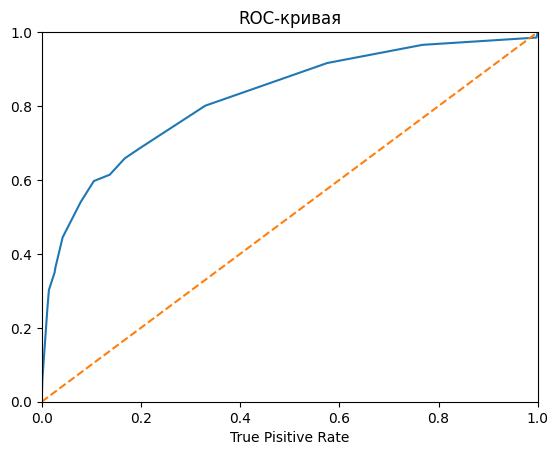

AUC-ROC: 0.8213794777671429
Accuracy: 0.8532064128256514
F1: 0.5526717557251909

TP: 181
TN: 1522
FP: 67
FN: 226

max_depth: 5


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [46]:
# Модель решающего дерева без балансировки классов
quality_metrics = DecisionTreeClassifier_SelectionOfParametrs(
    features_train_wooden, target_train,
    features_valid_wooden, target_valid, 
    None, 'none', quality_metrics
)


Модель случайного леса без балансировки классов

In [47]:
# Функция поиска оптимального параметра n_estimators случайного леса
def RandomForestClassifier_SelectionOfParametrs_NEstimatorsItrator(
    features_train, target_train, 
    features_test, target_test, 
    class_weight, depth, n1, n2, n3
):
    n_estimators_f1 = pd.DataFrame(columns=['n_estimators', 'f1']) 
    for n in range(n1, n2, n3):
        model = RandomForestClassifier(
            class_weight=class_weight, 
            n_estimators=n, 
            max_depth=depth, 
            random_state=12345
        )
        model.fit(features_train, target_train)
        predictions_test = model.predict(features_test)
        
        n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({
            'n_estimators': [n], 
            'f1': [f1_score(target_test, predictions_test)]
        }), ignore_index=True) 
        print('n_estimators:', n)
        print('f1:', f1_score(target_test, predictions_test))
        print()
    
    result = n_estimators_f1.loc[n_estimators_f1['f1'] == n_estimators_f1['f1'].max(), 'n_estimators']
    #print(result)
    if len(result) > 1:
        result = int(result.loc[result == result.max()])
    else:
        result = int(result)
    
    return result

In [48]:
# Функция поиска оптимальных параметров для случайного леса
def RandomForestClassifier_SelectionOfParametrs(
    features_train, target_train, 
    features_test, target_test, 
    class_weight, balance_type, quality_metrics
):
    # Поиск max_depth
    depth_f1 = pd.DataFrame(columns=['depth', 'f1']) 
    for depth in range(1, 30, 1):
        model = RandomForestClassifier(
            class_weight=class_weight, 
            n_estimators=20, 
            max_depth=depth, 
            random_state=12345
        )
        model.fit(features_train, target_train)
        predictions_test = model.predict(features_test)
        
        depth_f1 = depth_f1.append(pd.DataFrame({
            'depth': [depth], 
            'f1': [f1_score(target_test, predictions_test)]
        }), ignore_index=True)
        print('max_depth:', depth)
        print('f1:', f1_score(target_test, predictions_test))
        print()
    
    depth = int(depth_f1.loc[depth_f1['f1'] == depth_f1['f1'].max(), 'depth'])
    
    # Поиск n_estimators крупными шагами
    n_estimators = RandomForestClassifier_SelectionOfParametrs_NEstimatorsItrator(
        features_train, target_train, 
        features_test, target_test, 
        class_weight, depth, 50, 252, 10
    )
    
    # Модель случайного леса с оптимальными параметрами
    model = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=depth, 
        random_state=12345
    )
    model.fit(features_train, target_train)
    predictions_test = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)

    # Анализ метрик качества моделей
    quality_metrics = output_of_quality_metrics(target_train, target_test, 
                                                predictions_test, probabilities_test, 
                                                quality_metrics, 
                                                'RandomForestClassifier', balance_type, 
                                                class_weight, depth, n_estimators
                                               )
    print('\nmax_depth:', depth)
    print('n_estimators:', n_estimators)
    
    return quality_metrics


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 1
f1: 0.11494252873563218

max_depth: 2
f1: 0.21748400852878466



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 3
f1: 0.21748400852878466

max_depth: 4
f1: 0.509274873524452



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 5
f1: 0.5174129353233831



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 6
f1: 0.5329153605015674



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 7
f1: 0.5217391304347826

max_depth: 8
f1: 0.552469135802469



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 9
f1: 0.5076923076923078



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 10
f1: 0.5351724137931034



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 11
f1: 0.5510688836104513



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 12
f1: 0.49791376912378293



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 13
f1: 0.5247524752475248



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 14
f1: 0.47538677918424754



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 15
f1: 0.5133991537376587



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 16
f1: 0.49360613810741694



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 17
f1: 0.5251908396946565



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 18
f1: 0.5255474452554745



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 19
f1: 0.5301914580265096



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 20
f1: 0.5185185185185186



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 21
f1: 0.5120481927710845



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 22
f1: 0.4773790951638066



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 23
f1: 0.4544



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 24
f1: 0.47846889952153115



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 25
f1: 0.46349206349206346



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 26
f1: 0.4728434504792333



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 27
f1: 0.46720000000000006



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 28
f1: 0.46720000000000006



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 29
f1: 0.46720000000000006



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 50
f1: 0.5623188405797102



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 60
f1: 0.5710144927536231



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 70
f1: 0.5693430656934306



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 80
f1: 0.5718518518518518



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 90
f1: 0.5735512630014858



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 100
f1: 0.5616641901931648



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 110
f1: 0.5672514619883041



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 120
f1: 0.5614035087719299



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 130
f1: 0.557037037037037



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 140
f1: 0.5617647058823529



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 150
f1: 0.5612998522895126



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 160
f1: 0.5538922155688623



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 170
f1: 0.5532544378698225



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 180
f1: 0.552870090634441



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 190
f1: 0.5495495495495495



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 200
f1: 0.5555555555555556



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 210
f1: 0.5547226386806597



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 220
f1: 0.5585585585585586



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 230
f1: 0.5542168674698795



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 240
f1: 0.5542168674698795



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 250
f1: 0.5555555555555556



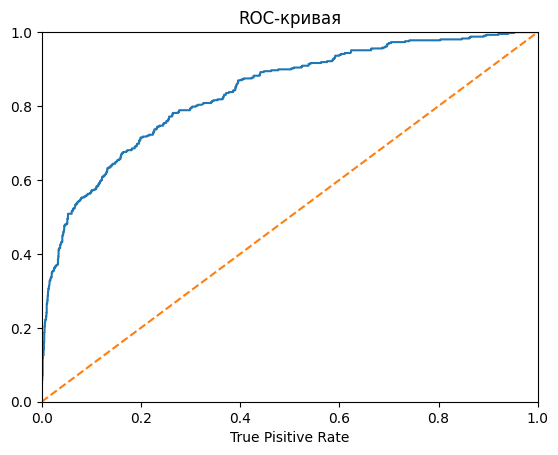

AUC-ROC: 0.8370778524963547
Accuracy: 0.8562124248496994
F1: 0.5735512630014858

TP: 193
TN: 1516
FP: 73
FN: 214

max_depth: 8
n_estimators: 90


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [49]:
# Модель случайного леса без балансировки классов
quality_metrics = RandomForestClassifier_SelectionOfParametrs(
    features_train_wooden, target_train, 
    features_valid_wooden, target_valid, 
    None, 'none', quality_metrics
)


Проверка на мультиколлинеарность выборок для логистических моделей

,number,id,age,years_registration,num_of_products,has_card,is_active,gender_Female,gender_Male,city_Екатеринбург,city_Москва,city_Санкт-Петербург,exited
number,1.000000,0.000045,-0.001943,-0.010368,0.015269,-0.007621,0.021751,-0.417534,-0.490022,-0.455854,-0.283541,-0.295659,0.002373
id,0.000045,1.000000,-0.002536,-0.017628,0.019867,-0.010579,0.002978,-0.001127,0.001316,-0.006059,0.016028,-0.008018,-0.014063
age,-0.001943,-0.002536,1.000000,-0.010170,-0.016154,-0.012094,0.096178,-0.004121,0.001774,0.021715,-0.013336,-0.017217,0.288363
years_registration,-0.010368,-0.017628,-0.010170,1.000000,0.007917,0.016880,-0.029659,0.019366,-0.003874,0.000636,0.018693,-0.000652,-0.010706
num_of_products,0.015269,0.019867,-0.016154,0.007917,1.000000,0.014449,-0.003077,-0.019912,0.005443,0.004103,-0.000560,-0.022276,-0.025332
has_card,-0.007621,-0.010579,-0.012094,0.016880,0.014449,1.000000,-0.008299,0.006116,-0.001895,-0.003287,0.001967,0.007341,-0.021298
is_active,0.021751,0.002978,0.096178,-0.029659,-0.003077,-0.008299,1.000000,-0.001763,-0.018459,-0.007843,-0.008993,-0.007436,-0.142575
gender_Female,-0.417534,-0.001127,-0.004121,0.019366,-0.019912,0.006116,-0.001763,1.000000,-0.424723,0.251749,0.194050,0.165055,0.001235
gender_Male,-0.490022,0.001316,0.001774,-0.003874,0.005443,-0.001895,-0.018459,-0.424723,1.000000,0.318841,0.178366,0.202640,-0.011916
city_Екатеринбург,-0.455854,-0.006059,0.021715,0.000636,0.004103,-0.003287,-0.007843,0.251749,0.318841,1.000000,-0.274790,-0.272465,-0.004494


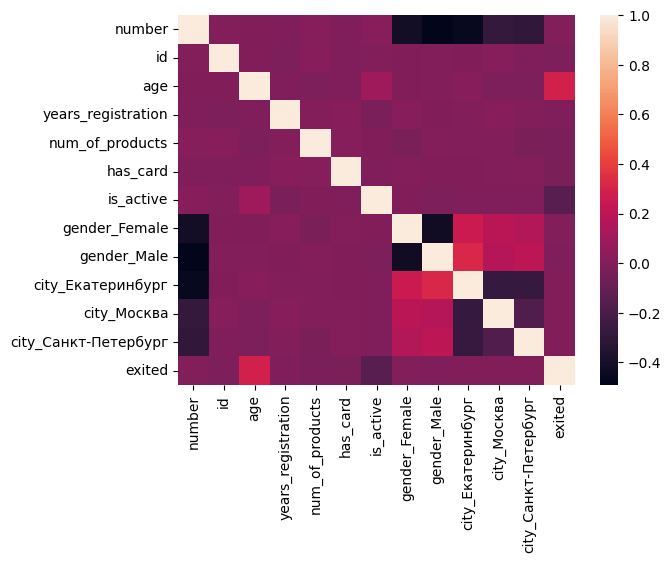

In [50]:
sns.heatmap(features_train_logistic.join(target_train).corr()) 
features_train_logistic.join(target_train).corr()

Проверка на мультиколлинеарность тестовых выборок

,number,id,age,years_registration,num_of_products,has_card,is_active,gender_Female,gender_Male,city_Екатеринбург,city_Москва,city_Санкт-Петербург,exited
number,1.000000,0.024422,0.026616,-0.005495,-0.014734,0.006337,0.029466,-0.435375,-0.466545,-0.462553,-0.289254,-0.317023,-0.058434
id,0.024422,1.000000,0.020775,-0.019292,0.014477,-0.017682,-0.018080,-0.032912,-0.010409,-0.001085,-0.018174,-0.039706,-0.006868
age,0.026616,0.020775,1.000000,-0.022586,-0.057882,-0.005019,0.071413,-0.034614,-0.030495,-0.018989,-0.020820,-0.042851,0.280332
years_registration,-0.005495,-0.019292,-0.022586,1.000000,0.040546,0.055738,-0.028003,-0.021017,0.044050,-0.001865,0.015799,0.022568,-0.015267
num_of_products,-0.014734,0.014477,-0.057882,0.040546,1.000000,0.003255,0.032531,0.047035,-0.007115,0.000424,0.047592,0.006835,-0.073714
has_card,0.006337,-0.017682,-0.005019,0.055738,0.003255,1.000000,-0.011141,-0.011635,0.003695,-0.023689,0.010672,0.013123,0.019918
is_active,0.029466,-0.018080,0.071413,-0.028003,0.032531,-0.011141,1.000000,0.011539,-0.049080,-0.027814,0.006903,-0.021850,-0.171880
gender_Female,-0.435375,-0.032912,-0.034614,-0.021017,0.047035,-0.011635,0.011539,1.000000,-0.103654,0.439846,0.310458,0.265677,-0.010059
gender_Male,-0.466545,-0.010409,-0.030495,0.044050,-0.007115,0.003695,-0.049080,-0.103654,1.000000,0.481646,0.270328,0.352967,0.047750
city_Екатеринбург,-0.462553,-0.001085,-0.018989,-0.001865,0.000424,-0.023689,-0.027814,0.439846,0.481646,1.000000,-0.069122,-0.074184,0.027564


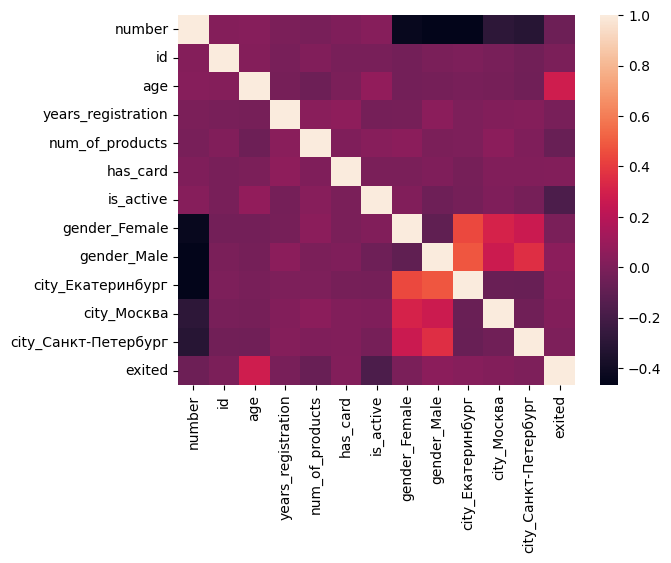

In [51]:
sns.heatmap(features_valid_logistic.join(target_valid).corr()) 
features_valid_logistic.join(target_valid).corr()

Модель логистической регрессии без балансировки классов

In [52]:
# Функция поиска оптимальных параметров для логистической регрессии
def LogisticRegression_SelectionOfParametrs(
    features_train, target_train, 
    features_test, target_test, 
    class_weight, balance_type, quality_metrics
):
    # Пробное обучение методом логистической регрессии
    model = LogisticRegression(
        solver='liblinear', 
        class_weight=class_weight, 
        random_state=12345
    ) 
    model.fit(features_train, target_train)
    predictions_test = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)

    # Анализ метрик качества моделей
    quality_metrics = output_of_quality_metrics(target_train, target_test, 
                                                predictions_test, probabilities_test, 
                                                quality_metrics, 'LogisticRegression', balance_type, 
                                                class_weight, None, None
                                               )
    return quality_metrics

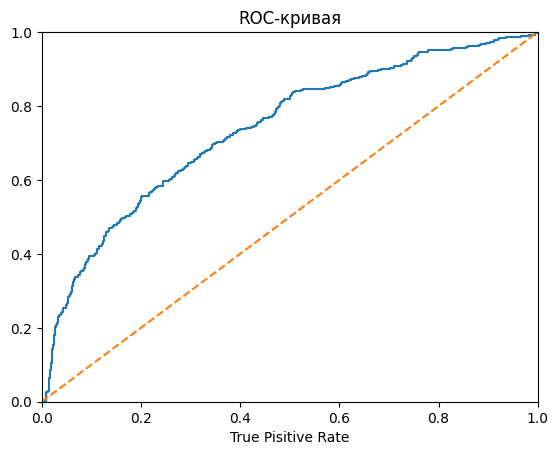

AUC-ROC: 0.7374950326492176
Accuracy: 0.814128256513026
F1: 0.3116883116883116

TP: 84
TN: 1541
FP: 48
FN: 323


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [53]:
# Модель логистической регрессии без балансировки классов
quality_metrics = LogisticRegression_SelectionOfParametrs(
    features_train_logistic, target_train, 
    features_valid_logistic, target_valid, 
    None, 'none', quality_metrics
)

Таблица изменения значений показателей качества моделей

In [54]:
quality_metrics.sort_values('f1', ascending=False)

,model,sample,auc_roc,accuracy,f1,class_weight,max_depth,n_estimators
1,RandomForestClassifier,none,0.837078,0.856212,0.573551,None,8,90
0,DecisionTreeClassifier,none,0.821379,0.853206,0.552672,None,5,None
2,LogisticRegression,none,0.737495,0.814128,0.311688,None,None,None


Исследование баланса классов

In [55]:
print('Уникальные классы целевого признака:') 
print(target_train.unique()) 
print() 
print('Количество объектов каждого класса целевого признака:') 
for i in target_train.unique():
    print(f'Класс "{i}" =', len(target_train.loc[target_train == i])) 


Уникальные классы целевого признака:
[0 1]

Количество объектов каждого класса целевого признака:
Класс "0" = 4767
Класс "1" = 1221


In [56]:
print('Отношение класса "1." к классу "0." целевого признака:') 
class_ratio = len(target_train.loc[target_train == 0]) / len(target_train.loc[target_train == 1]) 
class_ratio

Отношение класса "1." к классу "0." целевого признака:


3.904176904176904

Модель решающего дерева с балансировкой весов классов внутри модели

C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 1
f1: 0.4854186265286924

max_depth: 2
f1: 0.5177757520510483

max_depth: 3
f1: 0.4854186265286924

max_depth: 4
f1: 0.5237633365664404



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 5
f1: 0.5434782608695652

max_depth: 6
f1: 0.4994708994708995

max_depth: 7
f1: 0.46684831970935514

max_depth: 8
f1: 0.39624608967674657

max_depth: 9
f1: 0.4000000000000001



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 10
f1: 0.35749751737835156

max_depth: 11
f1: 0.34623655913978496

max_depth: 12
f1: 0.31784841075794623

max_depth: 13
f1: 0.3200962695547533



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 14
f1: 0.32160804020100503

max_depth: 15
f1: 0.31630170316301703

max_depth: 16
f1: 0.3139678615574784



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 17
f1: 0.3124231242312423

max_depth: 18
f1: 0.31435643564356436

max_depth: 19
f1: 0.31488314883148827

max_depth: 20
f1: 0.31592039800995025

max_depth: 21
f1: 0.31460674157303375

max_depth: 22
f1: 0.3156596794081381

max_depth: 23
f1: 0.3122676579925651



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 24
f1: 0.31527093596059114

max_depth: 25
f1: 0.31435643564356436

max_depth: 26
f1: 0.31435643564356436



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 27
f1: 0.31435643564356436

max_depth: 28
f1: 0.31435643564356436



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 29
f1: 0.31435643564356436



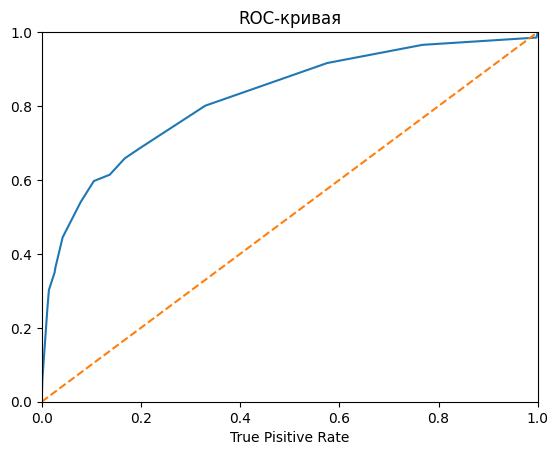

AUC-ROC: 0.8213794777671429
Accuracy: 0.8532064128256514
F1: 0.5526717557251909

TP: 181
TN: 1522
FP: 67
FN: 226

max_depth: 5


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [57]:
quality_metrics = DecisionTreeClassifier_SelectionOfParametrs(
    features_train_wooden, target_train, 
    features_valid_wooden, target_valid, 
    'balanced', 'balance', quality_metrics
)

Модель случайного леса с балансировкой весов классов внутри модели

C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 1
f1: 0.5177757520510483

max_depth: 2
f1: 0.5177757520510483



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 3
f1: 0.553191489361702

max_depth: 4
f1: 0.5791666666666666



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 5
f1: 0.549127640036731

max_depth: 6
f1: 0.6060606060606061



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 7
f1: 0.54524627720504



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 8
f1: 0.5590643274853802



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 9
f1: 0.4906204906204906



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 10
f1: 0.4728915662650603



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 11
f1: 0.5188284518828451



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 12
f1: 0.3090909090909091



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 13
f1: 0.3986486486486487



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 14
f1: 0.19246861924686193



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 15
f1: 0.4625407166123779



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 16
f1: 0.46598639455782315



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 17
f1: 0.46050420168067224



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 18
f1: 0.42328042328042326



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 19
f1: 0.4036697247706423



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 20
f1: 0.4301075268817205



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 21
f1: 0.44086021505376344



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 22
f1: 0.4231464737793851



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 23
f1: 0.3867403314917127



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 24
f1: 0.27878787878787875



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 25
f1: 0.3326810176125245



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 26
f1: 0.3346153846153846



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 27
f1: 0.3346153846153846



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 28
f1: 0.3346153846153846



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 29
f1: 0.3346153846153846



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 50
f1: 0.5978494623655914



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 60
f1: 0.6017316017316017



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 70
f1: 0.6036519871106337



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 80
f1: 0.5991379310344828



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 90
f1: 0.6017505470459518



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 100
f1: 0.5989304812834225



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 110
f1: 0.5916398713826366



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 120
f1: 0.5916398713826366



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 130
f1: 0.596340150699677



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 140
f1: 0.5978494623655914



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 150
f1: 0.5982905982905982



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 160
f1: 0.5991471215351812



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 170
f1: 0.5959271168274384



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 180
f1: 0.5937161430119178



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 190
f1: 0.596529284164859



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 200
f1: 0.596529284164859



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 210
f1: 0.5986984815618221



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 220
f1: 0.5978260869565218



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 230
f1: 0.5980498374864571



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 240
f1: 0.5991379310344828



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 250
f1: 0.5976267529665588



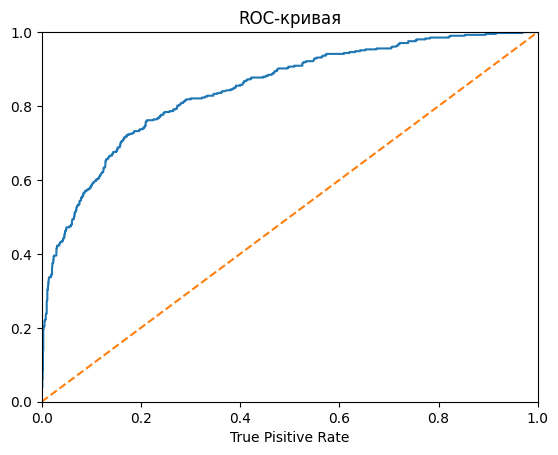

AUC-ROC: 0.8452505941492726
Accuracy: 0.8517034068136272
F1: 0.5432098765432098

TP: 176
TN: 1524
FP: 65
FN: 231

max_depth: 6
n_estimators: 70


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [58]:
quality_metrics = RandomForestClassifier_SelectionOfParametrs(
    features_train_wooden, target_train,
    features_valid_wooden, target_valid, 
    'balanced', 'balance', quality_metrics
)

Модель логистической регрессии с балансировкой весов классов внутри модели

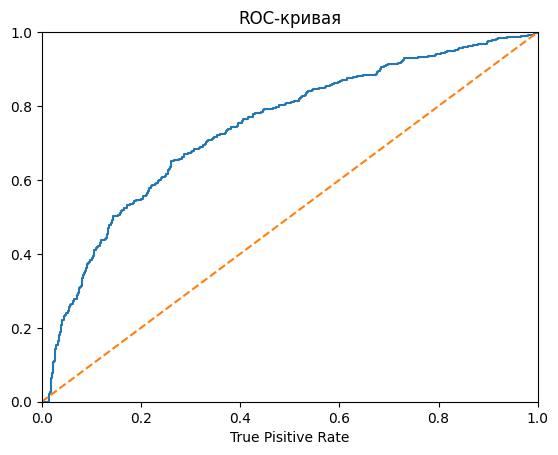

AUC-ROC: 0.7407931989429787
Accuracy: 0.658817635270541
F1: 0.4633569739952719

TP: 294
TN: 1021
FP: 568
FN: 113


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [59]:
quality_metrics = LogisticRegression_SelectionOfParametrs(
    features_train_logistic, target_train, 
    features_valid_logistic, target_valid, 
    'balanced', 'balance', quality_metrics
)

Таблица изменения значений показателей качества протестированных моделей

In [60]:
quality_metrics.sort_values('f1', ascending=False)

,model,sample,auc_roc,accuracy,f1,class_weight,max_depth,n_estimators
1,RandomForestClassifier,none,0.837078,0.856212,0.573551,None,8,90
0,DecisionTreeClassifier,none,0.821379,0.853206,0.552672,None,5,None
3,DecisionTreeClassifier,balance,0.821379,0.853206,0.552672,balanced,5,None
4,RandomForestClassifier,balance,0.845251,0.851703,0.543210,balanced,6,70
5,LogisticRegression,balance,0.740793,0.658818,0.463357,balanced,None,None
2,LogisticRegression,none,0.737495,0.814128,0.311688,None,None,None


Использование параметра `class_weight='balanced'`, балансирующей веса классов, в модели логистической регрессии привело к следющим изменениям показателей качества модели:
1. Две из трех моделей без балансировки весов классов имеют лучшее значение показателя `F1`. Лидер `DecisionTreeClassifier` со значением `F1` равным 0.552672.
1. Максимальное значение параметра `AUC-ROC` равное 0.845251 у сбалансированной модели `RandomForestClassifier`. 
1. Максимальное значение показателя `Accuracy` равное 0.856212 у несбалансированной модели `RandomForestClassifier`.

Разные модели в сбалансированном и несбалансированном состоянии показали разные значения настолько, что требуется долнительная проверка эффективности сбалансированных моделей.

In [61]:
# Универсальная функция изменения размера выборки
def changesizasample(features, target, class_change, change_type, class_ratio):
    # fetures - аттрибуты
    # target - целевой признак
    # class_change - класс (0, 1), размер которого требуется изменить
    # change_type - тип изменения выборки True (увеличение), False (уменьшение)
    # fraction - множитель для изменения
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if change_type == True:
        if class_change == 0:
            features_downloadsample = pd.concat([features_zeros] * int(class_ratio) + [features_ones])
            target_downloadsample = pd.concat([target_zeros] * int(class_ratio) + [target_ones])
        if class_change == 1:
            features_downloadsample = pd.concat([features_zeros] + [features_ones] * int(class_ratio))
            target_downloadsample = pd.concat([target_zeros] + [target_ones] * int(class_ratio))
    if change_type == False:
        if class_change == 0:
            features_zeros = features_zeros.sample(frac=class_ratio, random_state=12345)
            target_zeros = target_zeros.sample(frac=class_ratio, random_state=12345)
        if class_change == 1:
            features_ones = features_ones.sample(frac=class_ratio, random_state=12345)
            target_ones = target_ones.sample(frac=class_ratio, random_state=12345)
        features_downloadsample = pd.concat([features_zeros] + [features_ones])
        target_downloadsample = pd.concat([target_zeros] + [target_ones])
    
    features_downloadsample, target_downloadsample = shuffle(
        features_downloadsample, target_downloadsample, random_state=12345
    )
    
    return features_downloadsample, target_downloadsample

In [62]:
# Увеличение обучающей выборки за счет объектов класса "1" для "деревянных" моделей
features_train_changesizasample, target_train_changesizasample = changesizasample(
    features_train_wooden, 
    target_train, 
    1,              # класс целевой обучающей выборки
    True,           # увеличение выборки
    class_ratio     # кратность изменения (множитель/делитель)
)

print('Изменение размера выборок:')
print(features_train_wooden.shape, '->', features_train_changesizasample.shape)
print(target_train.shape, '->', target_train_changesizasample.shape)

Изменение размера выборок:
(5988, 9) -> (8430, 9)
(5988,) -> (8430,)


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 1
f1: 0.4854186265286924

max_depth: 2
f1: 0.5177757520510483

max_depth: 3
f1: 0.5006839945280438

max_depth: 4
f1: 0.5239085239085239

max_depth: 5
f1: 0.5434782608695652

max_depth: 6
f1: 0.5051194539249146

max_depth: 7
f1: 0.5199543899657925

max_depth: 8
f1: 0.3789704271631983



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 9
f1: 0.383756345177665

max_depth: 10
f1: 0.3517169614984391

max_depth: 11
f1: 0.3507692307692308



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 12
f1: 0.30787037037037035

max_depth: 13
f1: 0.3250270855904659

max_depth: 14
f1: 0.32630410654827974



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 15
f1: 0.32612966601178783

max_depth: 16
f1: 0.3078602620087336

max_depth: 17
f1: 0.3194888178913738

max_depth: 18
f1: 0.3147410358565737

max_depth: 19
f1: 0.32905982905982906



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 20
f1: 0.31063829787234043

max_depth: 21
f1: 0.31106471816283926

max_depth: 22
f1: 0.3227848101265823

max_depth: 23
f1: 0.3068432671081677

max_depth: 24
f1: 0.3227132579650565



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 25
f1: 0.32210526315789473

max_depth: 26
f1: 0.3270189431704886

max_depth: 27
f1: 0.3264462809917355

max_depth: 28
f1: 0.3238095238095238

max_depth: 29
f1: 0.32916666666666666



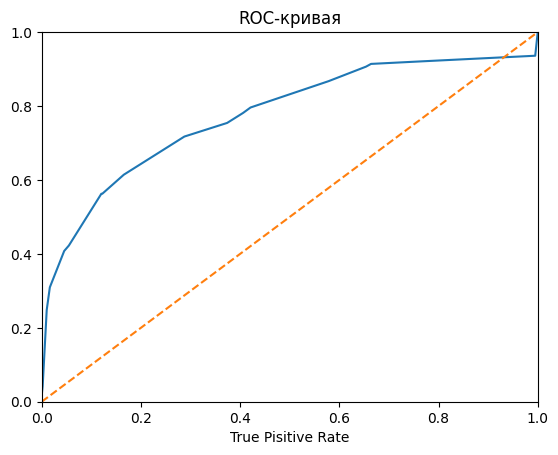

AUC-ROC: 0.7755638812907536
Accuracy: 0.7895791583166333
F1: 0.5434782608695652

TP: 250
TN: 1326
FP: 263
FN: 157

max_depth: 5


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [63]:
# Модель решающего дерева со сблансированной обучающей выборкой, 
# полученной путем увеличения количества объектов класса "1"
quality_metrics = DecisionTreeClassifier_SelectionOfParametrs(
    features_train_changesizasample, target_train_changesizasample, 
    features_valid_wooden, target_valid, 
    None, 'up_sample', quality_metrics
)

C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 1
f1: 0.5194029850746268

max_depth: 2
f1: 0.5414585414585414



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 3
f1: 0.5646328852119958



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 4
f1: 0.5937500000000001



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 5
f1: 0.6016073478760047



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 6
f1: 0.5864332603938731



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 7
f1: 0.5948372615039281



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 8
f1: 0.5585774058577407



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 9
f1: 0.5692137320044296



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 10
f1: 0.5642317380352645



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 11
f1: 0.47509578544061304



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 12
f1: 0.5031605562579012



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 13
f1: 0.5049019607843137



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 14
f1: 0.47375160051216386



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 15
f1: 0.49814126394052044



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 16
f1: 0.47346938775510206



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 17
f1: 0.5110246433203632



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 18
f1: 0.45526315789473687



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 19
f1: 0.5013192612137204



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 20
f1: 0.46461949265687585



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 21
f1: 0.480106100795756



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 22
f1: 0.49740932642487046



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 23
f1: 0.4999999999999999



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 24
f1: 0.5111989459815547



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 25
f1: 0.5178335535006605



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 26
f1: 0.5170603674540682



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 27
f1: 0.5113788487282462



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 28
f1: 0.5113788487282462



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 29
f1: 0.5113788487282462



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 50
f1: 0.5883668903803131



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 60
f1: 0.591676040494938



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 70
f1: 0.6022727272727273



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 80
f1: 0.6022727272727273



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 90
f1: 0.6047565118912798



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 100
f1: 0.6002239641657335



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 110
f1: 0.6085972850678733



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 120
f1: 0.6049661399548533



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 130
f1: 0.6058558558558558



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 140
f1: 0.6056497175141242



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 150
f1: 0.6118721461187214



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 160
f1: 0.6077097505668934



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 170
f1: 0.6077097505668934



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 180
f1: 0.6029246344206973



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 190
f1: 0.598194130925508



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 200
f1: 0.6011299435028248



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 210
f1: 0.6022727272727273



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 220
f1: 0.5993189557321227



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 230
f1: 0.6009070294784581



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 240
f1: 0.6015891032917138



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 250
f1: 0.6027088036117381



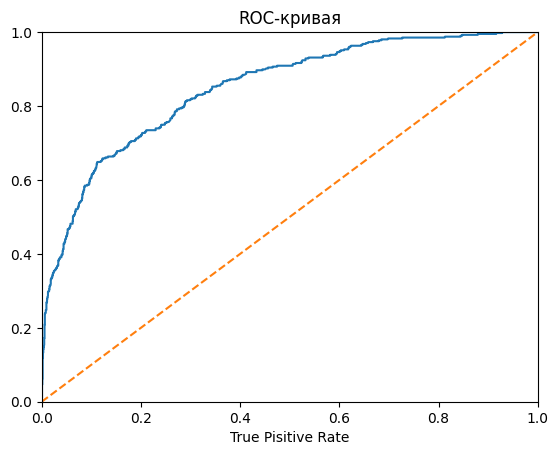

AUC-ROC: 0.8484273792643837
Accuracy: 0.8296593186372746
F1: 0.6118721461187214

TP: 268
TN: 1388
FP: 201
FN: 139

max_depth: 5
n_estimators: 150


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [64]:
# Модель случайного леса со сблансированной обучающей выборкой, 
# полученной путем увеличения количества объектов класса "1"
quality_metrics = RandomForestClassifier_SelectionOfParametrs(
    features_train_changesizasample, target_train_changesizasample,
    features_valid_wooden, target_valid, 
    None, 'up_sample', quality_metrics
)

In [65]:
# Увеличение обучающей выборки за счет объектов класса "1" для логистических" моделей
features_train_changesizasample, target_train_changesizasample = changesizasample(
    features_train_logistic, 
    target_train, 
    1,              # класс целевой обучающей выборки
    True,           # увеличение выборки
    class_ratio     # кратность изменения (множитель/делитель)
)

print('Изменение размера выборок:')
print(features_train_logistic.shape, '->', features_train_changesizasample.shape)
print(target_train.shape, '->', target_train_changesizasample.shape)

Изменение размера выборок:
(5988, 12) -> (8430, 12)
(5988,) -> (8430,)


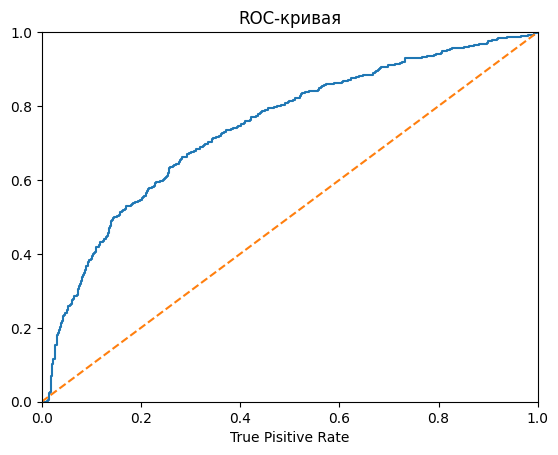

AUC-ROC: 0.740468484961877
Accuracy: 0.7219438877755511
F1: 0.4699140401146132

TP: 246
TN: 1195
FP: 394
FN: 161


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [66]:
# Модель логистической регрессии со сблансированной обучающей выборкой, 
# полученной путем увеличения количества объектов класса "1"
quality_metrics = LogisticRegression_SelectionOfParametrs(
    features_train_changesizasample, target_train_changesizasample, 
    features_valid_logistic, target_valid, 
    None, 'up_sample', quality_metrics
)


In [67]:
# Результаты использования моделей со сблансированной обучающей выборкой, 
# полученной путем увеличения количества объектов класса "1"

quality_metrics.sort_values('f1', ascending=False)

,model,sample,auc_roc,accuracy,f1,class_weight,max_depth,n_estimators
7,RandomForestClassifier,up_sample,0.848427,0.829659,0.611872,None,5,150
1,RandomForestClassifier,none,0.837078,0.856212,0.573551,None,8,90
0,DecisionTreeClassifier,none,0.821379,0.853206,0.552672,None,5,None
3,DecisionTreeClassifier,balance,0.821379,0.853206,0.552672,balanced,5,None
6,DecisionTreeClassifier,up_sample,0.775564,0.789579,0.543478,None,5,None
4,RandomForestClassifier,balance,0.845251,0.851703,0.543210,balanced,6,70
8,LogisticRegression,up_sample,0.740468,0.721944,0.469914,None,None,None
5,LogisticRegression,balance,0.740793,0.658818,0.463357,balanced,None,None
2,LogisticRegression,none,0.737495,0.814128,0.311688,None,None,None


In [68]:
# Балансировка классов за счет уменьшения обучающей выборки класса "0"
features_train_changesizasample, target_train_changesizasample = changesizasample(
    features_train_wooden, 
    target_train, 
    0,              # класс целевой обучающей выборки
    False,          # уменьшение выборки
    class_ratio/100 # кратность изменения (множитель/делитель)
)

print('Изменение размера выборок:')
print(features_train_wooden.shape, '->', features_train_changesizasample.shape)
print(target_train.shape, '->', target_train_changesizasample.shape)


Изменение размера выборок:
(5988, 9) -> (1407, 9)
(5988,) -> (1407,)


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 1
f1: 0.3387432376196421

max_depth: 2
f1: 0.3387432376196421

max_depth: 3
f1: 0.3387432376196421

max_depth: 4
f1: 0.35707925200356183

max_depth: 5
f1: 0.3531499556344277



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 6
f1: 0.3558118899733807

max_depth: 7
f1: 0.37476280834914616

max_depth: 8
f1: 0.3770651117589893

max_depth: 9
f1: 0.3834661354581673

max_depth: 10
f1: 0.4057142857142857

max_depth: 11
f1: 0.40458452722063043

max_depth: 12
f1: 0.4066437571592211

max_depth: 13
f1: 0.4077892325315006



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

max_depth: 14
f1: 0.40542066629023155

max_depth: 15
f1: 0.408092485549133

max_depth: 16
f1: 0.4029595902105863

max_depth: 17
f1: 0.3991006183249016

max_depth: 18
f1: 0.3991006183249016

max_depth: 19
f1: 0.3991006183249016

max_depth: 20
f1: 0.3991006183249016

max_depth: 21
f1: 0.3991006183249016

max_depth: 22
f1: 0.3991006183249016

max_depth: 23
f1: 0.3991006183249016

max_depth: 24
f1: 0.3991006183249016

max_depth: 25
f1: 0.3991006183249016

max_depth: 26
f1: 0.3991006183249016

max_depth: 27
f1: 0.3991006183249016

max_depth: 28
f1: 0.3991006183249016

max_depth: 29
f1: 0.3991006183249016



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\127661089.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\ple

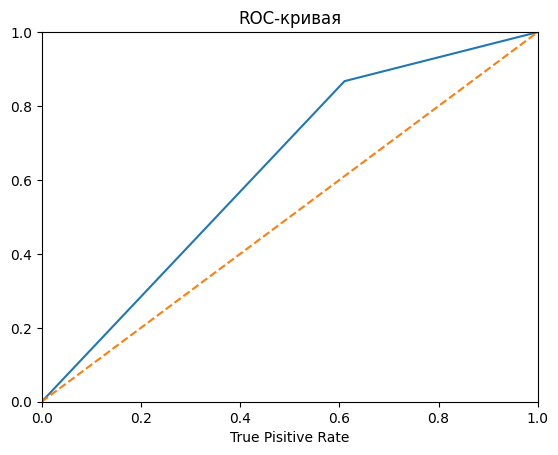

AUC-ROC: 0.6284375227106505
Accuracy: 0.48697394789579157
F1: 0.408092485549133

TP: 353
TN: 619
FP: 970
FN: 54

max_depth: 15


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [69]:
# Модель решающего дерева со сблансированной обучающей выборкой, 
# полученной путем уменьшения количества объектов класса "0"
quality_metrics = DecisionTreeClassifier_SelectionOfParametrs(
    features_train_changesizasample, target_train_changesizasample, 
    features_valid_wooden, target_valid, 
    None, 'down_sample', quality_metrics
)

C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 1
f1: 0.3387432376196421

max_depth: 2
f1: 0.3387432376196421

max_depth: 3
f1: 0.3387432376196421



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 4
f1: 0.3387432376196421

max_depth: 5
f1: 0.33959115561118064



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 6
f1: 0.35899731423455683



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 7
f1: 0.35704816615112683

max_depth: 8
f1: 0.3603765127745405



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 9
f1: 0.382295719844358

max_depth: 10
f1: 0.39150699119627136

max_depth: 11
f1: 0.3702664796633941



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 12
f1: 0.3644605621033545



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 13
f1: 0.3673659673659673

max_depth: 14
f1: 0.37775647171620325



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 15
f1: 0.39039039039039036

max_depth: 16
f1: 0.3934098851722416



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 17
f1: 0.3790786948176583

max_depth: 18
f1: 0.38577691183633706



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 19
f1: 0.38577691183633706

max_depth: 20
f1: 0.38577691183633706



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 21
f1: 0.38577691183633706

max_depth: 22
f1: 0.38577691183633706

max_depth: 23
f1: 0.38577691183633706



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 24
f1: 0.38577691183633706

max_depth: 25
f1: 0.38577691183633706



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({


max_depth: 26
f1: 0.38577691183633706

max_depth: 27
f1: 0.38577691183633706

max_depth: 28
f1: 0.38577691183633706



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\24899568.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  depth_f1 = depth_f1.append(pd.DataFrame({
C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


max_depth: 29
f1: 0.38577691183633706

n_estimators: 50
f1: 0.37054191755442334



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 60
f1: 0.3683241252302026



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 70
f1: 0.3677007299270073



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 80
f1: 0.36863823933975237



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 90
f1: 0.36536718041704447



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 100
f1: 0.36298292902066487



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 110
f1: 0.36437613019891496



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 120
f1: 0.3616734143049932



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 130
f1: 0.3621621621621622



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 140
f1: 0.36208445642407905



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 150
f1: 0.3621621621621622



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 160
f1: 0.362410071942446



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 170
f1: 0.3624943921040826



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 180
f1: 0.36298292902066487



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 190
f1: 0.36371800628648404



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 200
f1: 0.36257833482542523



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 210
f1: 0.3606411398040962



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 220
f1: 0.36128456735057984



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 230
f1: 0.3608017817371938



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 240
f1: 0.36112349531876947



C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\183344835.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  n_estimators_f1 = n_estimators_f1.append(pd.DataFrame({


n_estimators: 250
f1: 0.3598400710795202



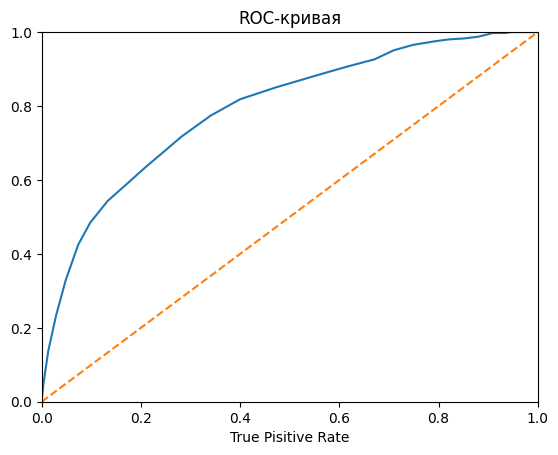

AUC-ROC: 0.7918683887846883
Accuracy: 0.3191382765531062
F1: 0.37054191755442334

TP: 400
TN: 237
FP: 1352
FN: 7

max_depth: 16
n_estimators: 50


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [70]:
# Модель случайного леса со сблансированной обучающей выборкой, 
# полученной путем уменьшения количества объектов класса "0"
quality_metrics = RandomForestClassifier_SelectionOfParametrs(
    features_train_changesizasample, target_train_changesizasample,
    features_valid_wooden, target_valid, 
    None, 'down_sample', quality_metrics
)

In [71]:
# Уменьшение обучающей выборки за счет объектов класса "0" для логистических моделей
features_train_changesizasample, target_train_changesizasample = changesizasample(
    features_train_logistic, 
    target_train, 
    0,              # класс целевой обучающей выборки
    False,          # уменьшение выборки
    class_ratio/100 # кратность изменения (множитель/делитель)
)

print('Изменение размера выборок:')
print(features_train_wooden.shape, '->', features_train_changesizasample.shape)
print(target_train.shape, '->', target_train_changesizasample.shape)


Изменение размера выборок:
(5988, 9) -> (1407, 12)
(5988,) -> (1407,)


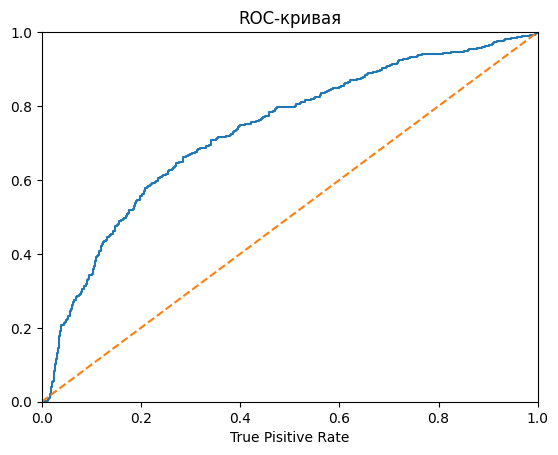

AUC-ROC: 0.7319114984313222
Accuracy: 0.22545090180360722
F1: 0.342687074829932

TP: 403
TN: 47
FP: 1542
FN: 4


C:\Users\pleskaks\AppData\Local\Temp\ipykernel_30768\3826688679.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quality_metrics = quality_metrics.append({


In [72]:
# Модель логистической регрессии со сблансированной обучающей выборкой, 
# полученной путем уменьшения количества объектов класса "0"
quality_metrics = LogisticRegression_SelectionOfParametrs(
    features_train_changesizasample, target_train_changesizasample, 
    features_valid_logistic, target_valid, 
    None, 'down_sample', quality_metrics
)

In [73]:
# Показатели качества моделей с разными способами балансировки 
# обучающих "деревянными" и логистических выборок и без нее
quality_metrics.sort_values('f1', ascending=False)

,model,sample,auc_roc,accuracy,f1,class_weight,max_depth,n_estimators
7,RandomForestClassifier,up_sample,0.848427,0.829659,0.611872,None,5,150
1,RandomForestClassifier,none,0.837078,0.856212,0.573551,None,8,90
0,DecisionTreeClassifier,none,0.821379,0.853206,0.552672,None,5,None
3,DecisionTreeClassifier,balance,0.821379,0.853206,0.552672,balanced,5,None
6,DecisionTreeClassifier,up_sample,0.775564,0.789579,0.543478,None,5,None
4,RandomForestClassifier,balance,0.845251,0.851703,0.543210,balanced,6,70
8,LogisticRegression,up_sample,0.740468,0.721944,0.469914,None,None,None
5,LogisticRegression,balance,0.740793,0.658818,0.463357,balanced,None,None
9,DecisionTreeClassifier,down_sample,0.628438,0.486974,0.408092,None,15,None
10,RandomForestClassifier,down_sample,0.791868,0.319138,0.370542,None,16,50


In [74]:
print('Лучшее значение показателей "F1", "Accuracy", "AUC-ROC":')
quality_metrics.loc[
    (quality_metrics['f1'] == quality_metrics['f1'].max()) |
    (quality_metrics['accuracy'] == quality_metrics['accuracy'].max()) |
    (quality_metrics['auc_roc'] == quality_metrics['auc_roc'].max())
]

Лучшее значение показателей "F1", "Accuracy", "AUC-ROC":


,model,sample,auc_roc,accuracy,f1,class_weight,max_depth,n_estimators
1,RandomForestClassifier,none,0.837078,0.856212,0.573551,None,8,90
7,RandomForestClassifier,up_sample,0.848427,0.829659,0.611872,None,5,150


Анализ показателей качества выявил наилучшую комбинацию модели и выборки. Это модель `RandomForestClassifier` с параметрами `n_estimators=8`, `max_depth=6`, `random_state=12345` с использованием сбалансированной обучающей выборки с увеличенным в 3 раза количеством объектов класса `1`. У этой комбинации самое лучшее значение показателя `F1`, равного 0.585434, и `AUC-ROC`, равного 0.832030. Только значение показателя `Accuracy` незначительно уступает этой же модели, но без балансировки.

In [76]:
# Рзультаты анализа метрик качества всех моделей с разными выборками
quality_metrics

,model,sample,auc_roc,accuracy,f1,class_weight,max_depth,n_estimators
0,DecisionTreeClassifier,none,0.821379,0.853206,0.552672,None,5,None
1,RandomForestClassifier,none,0.837078,0.856212,0.573551,None,8,90
2,LogisticRegression,none,0.737495,0.814128,0.311688,None,None,None
3,DecisionTreeClassifier,balance,0.821379,0.853206,0.552672,balanced,5,None
4,RandomForestClassifier,balance,0.845251,0.851703,0.543210,balanced,6,70
5,LogisticRegression,balance,0.740793,0.658818,0.463357,balanced,None,None
6,DecisionTreeClassifier,up_sample,0.775564,0.789579,0.543478,None,5,None
7,RandomForestClassifier,up_sample,0.848427,0.829659,0.611872,None,5,150
8,LogisticRegression,up_sample,0.740468,0.721944,0.469914,None,None,None
9,DecisionTreeClassifier,down_sample,0.628438,0.486974,0.408092,None,15,None
